In [1]:
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
    horizontal-align: middle;
}
h1 {
    text-align: center;
    background-color: AliceBlue;
    padding: 10px;
    margin: 0;
    font-family: monospace;
    color:DimGray;
    border-radius: 10px
}

h2 {
    text-align: center;
    background-color: HoneyDew;
    padding: 10px;
    margin: 0;
    font-family: monospace;
    color:DimGray;
    border-radius: 10px
}

h3 {
    text-align: center;
    background-color: MintCream;
    padding: 10px;
    margin: 0;
    font-family: monospace;
    color:DimGray;
    border-radius: 10px
}


body, p {
    font-family: monospace;
    font-size: 15px;
    color: charcoal;
}
div {
    font-size: 14px;
    margin: 0;

}

h4 {
    padding: 0px;
    margin: 0;
    font-family: monospace;
    color: purple;
}
</style>
""")

# Introduction to GAN 
**Generate MNIST Images (28 x 28 x 1) with a DCGAN.**

We will start with a basic dataset such as MNIST or Fashion MNIST, and then evolve and end up creating a notebook for the **"I'm Something of a Painter Myself"** competition.

Although this is the first notebook in the series, **we will see and use some of Soumith Chintala's famous GAN Hacks**. 
https://github.com/soumith/ganhacks

We are going to work with TensorFlow, Keras and Python.

You have a lot of explanations about this code in this article at Medium: 
https://medium.com/towards-artificial-intelligence/creating-our-first-optimized-dcgan-12edde5e34c6

# How does a GAN work?
A GAN is composed by two models, a **generator** and a **discriminator**, that work together.

The generator is responsible for creating the fake images, and the discriminator must determine which images are fake or true.

For now, we have a model that makes images and another that decides whether they are real or not. 

These models must work together until the generator model is capable of creating images that deceive the discriminator, and the discriminator is incapable of differentiating the real images from the generated ones.

## Libraries, Dataset & Support functions. 

In [2]:
#Import libraries
import tensorflow as tf
import tensorflow.keras as keras

import numpy as np
import matplotlib.pyplot as plt
from IPython import display

from keras.utils.vis_utils import plot_model

print (tf.__version__)

2.6.4


In [3]:
def plot_results(images, n_cols=None):
    '''visualizes fake images'''
    display.clear_output(wait=False)  

    n_cols = n_cols or len(images)
    n_rows = (len(images) - 1) // n_cols + 1

    if images.shape[-1] == 1:
        images = np.squeeze(images, axis=-1)

    plt.figure(figsize=(n_cols, n_rows))
    
    for index, image in enumerate(images):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(image, cmap="binary")
        plt.axis("off")

In [4]:
# download the training images
(X_train, _), _ = keras.datasets.mnist.load_data()

# normalize pixel values as is recommended in GAN Hacks
X_train = X_train.astype(np.float32) / 255

# reshape and rescale
X_train = X_train.reshape(-1, 28, 28, 1) * 2. - 1.

BATCH_SIZE = 128

# create batches of tensors to be fed into the model
dataset = tf.data.Dataset.from_tensor_slices(X_train)
dataset = dataset.shuffle(1000)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True).prefetch(1)

11501568/11490434 [==============================] - 0s 0us/step


## Generator

The Generator model should output a 28x28x1 image.

As input, it will receive noise, a vector of random data that follows a Gaussian distribution.

It will transform this input into fake images to send to the discriminator.

Mainly, it will perform two actions to get the output image. Learn to modify the data in order to create images that deceive the discriminator, and to upsize the data to reach its desired size. 

In [5]:
noise_input = 50

generator = keras.models.Sequential([
    #The first layer receives the noise
    keras.layers.Dense(7 * 7 * 128, input_shape=[noise_input], 
                       activation=keras.layers.LeakyReLU(alpha=0.2)),
    keras.layers.Reshape([7, 7, 128]),
    keras.layers.BatchNormalization(),

    #First UpSample doubling the size to 14x14
    keras.layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding="SAME", 
                                 activation=keras.layers.LeakyReLU(alpha=0.2)),
    keras.layers.BatchNormalization(),

    #Second UpSample doubling the size to 28x28
    keras.layers.Conv2DTranspose(1, kernel_size=4, strides=2, padding="SAME",
                                 activation='tanh'),

    #keras.layers.Conv2D(1, (7,7), activation='tanh', padding='same')                              
])

Data is upsampled using Layers *Conv2DTranspose*. The size of the upsamplig is indicated by the strides value. 

We are using the LeakyRelu layer as activation function. It allows having some negative results in the function. In our case, the value can be anywhere from -0.2 to 1. It is one of the GAN HAcks suggestions. 

The last layer have a tanh activation, which is also a GAN Hack. 


In [6]:
generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 6272)              319872    
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 128)         0         
_________________________________________________________________
batch_normalization (BatchNo (None, 7, 7, 128)         512       
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 14, 14, 128)       262272    
_________________________________________________________________
batch_normalization_1 (Batch (None, 14, 14, 128)       512       
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 28, 28, 1)         2049      
Total params: 585,217
Trainable params: 584,705
Non-trainable params: 512
________________________________________________

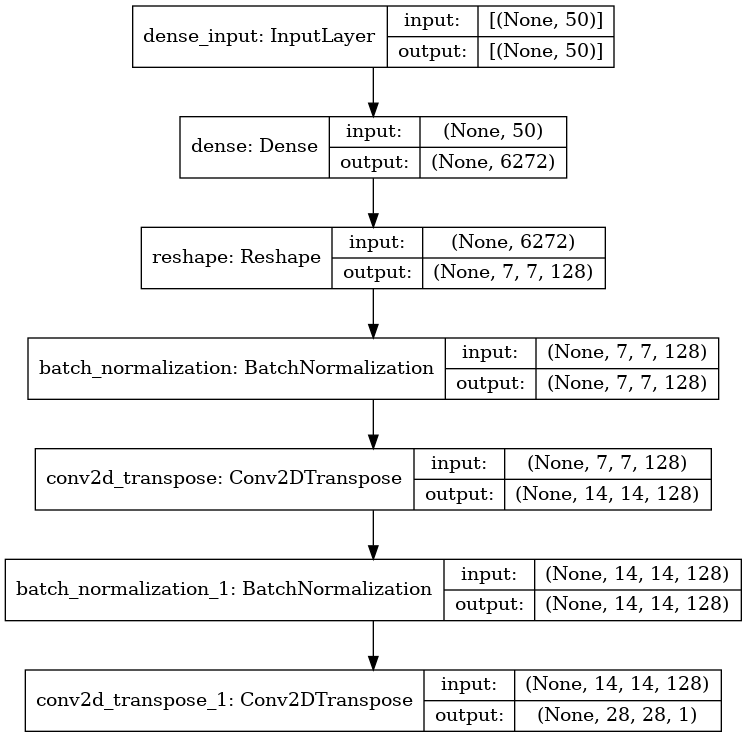

In [7]:
plot_model(generator, show_shapes=True, 
           show_layer_names=True)

### Testing the generator

shape of the generated batch: (16, 28, 28, 1)


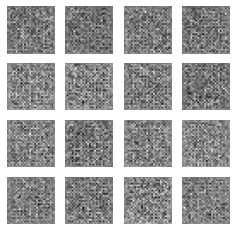

In [8]:
# generate a batch of noise input (batch size = 16)
#we got 16 noises to generate 16 images. 
test_noise = tf.random.normal([16, noise_input])

# feed the batch to the untrained generator
test_image = generator(test_noise)

# visualize sample output
plot_results(test_image, n_cols=4)

print(f'shape of the generated batch: {test_image.shape}')

The images are generated by our non trained Generator. 

## Discriminator

As input, it will receive a 28x28x1 image and as output it will have a binary value.

The discriminator model is simpler than the generator. We use convolutional layers and a stride of 2, so the input data size is halved.

Some of the recommendations made by Soumith Chintala are used, such as the use of LeakyRelu activators, or the use of Dropout layers.

The data is flattened with the Flatten layer before passing to the last dense layer. Because we are only interested in the values 0 and 1, we use a sigmoid trigger for the final Dense layer. It is used to identify the image as false or authentic.

In [9]:
discriminator = keras.models.Sequential([
    keras.layers.Conv2D(64, kernel_size=5, strides=2, padding="SAME",
                        activation=keras.layers.LeakyReLU(0.2),
                        input_shape=[28, 28, 1]),
    keras.layers.Dropout(0.4),
    keras.layers.Conv2D(64, kernel_size=3, strides=2, padding="SAME",
                        activation=keras.layers.LeakyReLU(0.2)),
    keras.layers.Dropout(0.4),
    keras.layers.Flatten(),
    keras.layers.Dense(1, activation="sigmoid")
])

In [10]:
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 14, 14, 64)        1664      
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 64)          36928     
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 7, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 3136)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 3137      
Total params: 41,729
Trainable params: 41,729
Non-trainable params: 0
__________________________________________________

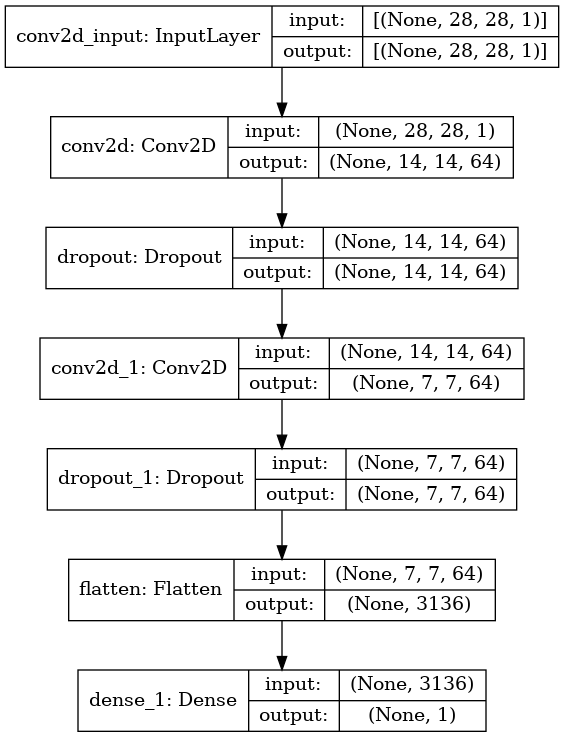

In [11]:
plot_model(discriminator, show_shapes=True, 
           show_layer_names=True)

You can see the reduction produced by the Conv2D layer. 

In [12]:
#The Adam optimizer is configured according to the recommended configuration in GAN Hacks. 
optimizer = keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
discriminator.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

#mark the layes of the discriminator as non trainables. 
discriminator.trainable = False

## Create and train the GAN

In [13]:
#The gan is formed by the generator and the discriminator
gan = keras.models.Sequential([generator, discriminator])

#we use the same optimize as for the discriminator
gan.compile(loss="binary_crossentropy", optimizer=optimizer)

gan.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 28, 28, 1)         585217    
_________________________________________________________________
sequential_1 (Sequential)    (None, 1)                 41729     
Total params: 626,946
Trainable params: 584,705
Non-trainable params: 42,241
_________________________________________________________________


This function trains the GAN in two phases. In the first one, the discriminator is trained. In a second, the discriminator layers are marked as not trainable, and the generator is trained.

In [ ]:
def train_gan(gan, dataset, random_normal_dimensions, n_epochs=30):
    
    #WWe obtained the generator and discriminator from the layers of the GAN model.
    generator, discriminator = gan.layers
    
    for epoch in range(n_epochs):
        print("Epoch {}/{}".format(epoch + 1, n_epochs))       
        
        #The data is organized into batches when we load it.
        for real_images in dataset:
            # infer batch size from the training batch
            batch_size = real_images.shape[0]

            # Train the discriminator 
            # create the random gaussian noise
            noise = tf.random.normal(shape=[batch_size, random_normal_dimensions])

            # Generate fake images from the noise
            fake_images = generator(noise)

            # create a list by concatenating the fake images with the real ones
            mixed_images = tf.concat([fake_images, real_images], axis=0)

            # Create the labels for the discriminator
            # 0 for the fake images
            # 1 for the real images
            discriminator_labels = tf.constant([[0.]] * batch_size + [[1.]] * batch_size)

            # mark the discriminator as trainable
            discriminator.trainable = True

            # use train_on_batch to train the discriminator.
            discriminator.train_on_batch(mixed_images, discriminator_labels)

            # Train the generator
            # create a new batch of random noise 
            noise = tf.random.normal(shape=[batch_size, random_normal_dimensions])
            
            # label all generated FAKE images as "real ones"
            generator_labels = tf.constant([[1.]] * batch_size)

            # Mark the discriminator as non trainable. 
            discriminator.trainable = False

            # train the GAN on the noise with the labels all set to be true
            gan.train_on_batch(noise, generator_labels)
        
        # plot the fake images used to train the discriminator
        plot_results(fake_images, 8)                     
        plt.show()

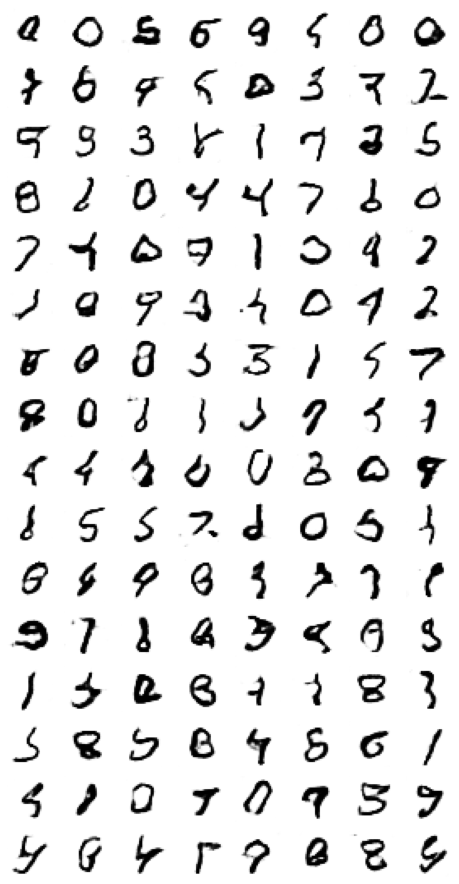

In [15]:
train_gan(gan, dataset, noise_input, 30)

# Conclusions, Fork & Improve

As you can see, the result has been good! 

After training for only 30 epochs, we have been able to achieve a result very similar to that of the original dataset.

If you want to fork and improve the GAN just use some of the other GAN Hacks recommendations. https://github.com/soumith/ganhacks

If I had to choose, I would possibly implement the smoothing of the labels. I think it is easy to do and will give us fun at the same time.

Or just try with another Dataset, the fashion MNIST can be an adequate candidate. 

## If you liked the notebook, please consider **upvoting it**. I will be very happy, and it encourages me to continue publishing.


## Continue with the next notebook in the GAN Tutorial: 

Generating Image Colors. Where we will use more GAN Hacks and wtite two functions to create customizable GANs. 

https://www.kaggle.com/code/peremartramanonellas/gan-tutorial-2-generating-color-images
